## 1. SETUP & CONFIGURATION

In [1]:
import cv2
import numpy as np
import pandas as pd
from pathlib import Path
import matplotlib.pyplot as plt
from matplotlib.gridspec import GridSpec
from typing import Tuple, Dict, List
import warnings
warnings.filterwarnings('ignore')

# Set style for better visualizations
plt.style.use('seaborn-v0_8-darkgrid')
%matplotlib inline

In [2]:
# ========== CONFIGURATION ==========
# Paths
ROI_DIR = Path("../data/interim/processed_rois")
OUTPUT_DIR = Path("../data/interim")
OUTPUT_DIR.mkdir(parents=True, exist_ok=True)

# Sharpness Parameters (Suggested - to be calibrated)
SHARPNESS_THRESHOLD = 100.0  # Variance threshold for blur detection
QUALITY_THRESHOLD = 0.4  # Minimum Q_S to pass

# Visualization
SAMPLE_SIZE = 10  # Number of images to show in examples
RANDOM_SEED = 42

## 2. CORE FUNCTIONS

In [3]:
def calculate_sharpness_metric(image: np.ndarray) -> float:
    """
    Calculate sharpness metric using Laplacian Variance.

    Args:
        image: Input image (BGR or Grayscale)

    Returns:
        Sharpness metric (M_S) - variance of Laplacian

    Theory:
        - Laplacian operator computes 2nd derivative (edge detection)
        - Sharp images have high variance (strong edges)
        - Blurry images have low variance (weak edges)
    """
    # Convert to grayscale if needed
    if len(image.shape) == 3:
        gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
    else:
        gray = image

    # Apply Laplacian operator
    laplacian = cv2.Laplacian(gray, cv2.CV_64F)

    # Calculate variance
    variance = laplacian.var()

    return variance


def sharpness_quality_clipped_linear(metric: float, threshold: float = 100.0) -> float:
    """
    Map sharpness metric to quality score using clipped linear function.

    Args:
        metric: Sharpness metric (M_S)
        threshold: Threshold value for saturation

    Returns:
        Quality score Q_S in range [0.0, 1.0]

    Formula:
        Q_S = min(M_S / Threshold, 1.0)
    """
    quality = metric / threshold
    return min(quality, 1.0)


def analyze_sharpness(image_path: Path, threshold: float = 100.0) -> Dict[str, float]:
    """
    Analyze sharpness for a single image.

    Args:
        image_path: Path to the image file
        threshold: Sharpness threshold for quality mapping

    Returns:
        Dictionary containing:
            - 'metric': Sharpness metric (M_S)
            - 'quality': Quality score (Q_S)
            - 'pass': Boolean indicating if image passes threshold
    """
    # Read image
    image = cv2.imread(str(image_path))
    if image is None:
        raise ValueError(f"Failed to load image: {image_path}")

    # Calculate metric
    metric = calculate_sharpness_metric(image)

    # Calculate quality score
    quality = sharpness_quality_clipped_linear(metric, threshold)

    return {"metric": metric, "quality": quality, "pass": quality >= QUALITY_THRESHOLD}

## 3. BATCH PROCESSING

In [4]:
def process_all_images(roi_dir: Path, threshold: float) -> pd.DataFrame:
    """
    Process all images in the ROI directory.

    Args:
        roi_dir: Directory containing ROI images
        threshold: Sharpness threshold for quality mapping

    Returns:
        DataFrame with analysis results
    """
    results = []
    image_files = sorted(roi_dir.glob("*.jpg")) + sorted(roi_dir.glob("*.png"))

    print(f"Processing {len(image_files)} images...")

    for i, img_path in enumerate(image_files, 1):
        try:
            result = analyze_sharpness(img_path, threshold)
            results.append(
                {
                    "filename": img_path.name,
                    "sharpness_metric": result["metric"],
                    "quality_score": result["quality"],
                    "status": "PASS" if result["pass"] else "REJECT",
                }
            )

            if i % 100 == 0:
                print(f"  Processed: {i}/{len(image_files)}")

        except Exception as e:
            print(f"  Error processing {img_path.name}: {e}")
            continue

    df = pd.DataFrame(results)
    print(f"\n✓ Complete: {len(df)} images analyzed")
    return df

In [5]:
# Run batch processing
df_results = process_all_images(ROI_DIR, SHARPNESS_THRESHOLD)
df_results.head(10)

Processing 706 images...
  Processed: 100/706
  Processed: 200/706
  Processed: 300/706
  Processed: 400/706
  Processed: 500/706
  Processed: 600/706
  Processed: 700/706

✓ Complete: 706 images analyzed


,filename,sharpness_metric,quality_score,status
0,0000065.jpg,371.582210,1.0,PASS
1,0000088.jpg,1987.034079,1.0,PASS
2,0000089.jpg,309.645866,1.0,PASS
3,0000155.jpg,293.676590,1.0,PASS
4,0000160.jpg,809.588133,1.0,PASS
5,0000164.jpg,1473.255025,1.0,PASS
6,0000186.jpg,314.893201,1.0,PASS
7,0000204.jpg,1016.102364,1.0,PASS
8,0000267.jpg,561.352672,1.0,PASS
9,0000287.jpg,872.413556,1.0,PASS


## 4. STATISTICAL ANALYSIS

In [6]:
# Overall statistics
print("=" * 60)
print("SHARPNESS ANALYSIS SUMMARY")
print("=" * 60)
print(f"Total Images: {len(df_results)}")
print(f"\nStatus Distribution:")
print(df_results["status"].value_counts())
print(
    f"\nPass Rate: {(df_results['status'] == 'PASS').sum() / len(df_results) * 100:.2f}%"
)
print("\n" + "-" * 60)
print("Sharpness Metric (M_S) Statistics:")
print(df_results["sharpness_metric"].describe())
print("\n" + "-" * 60)
print("Quality Score (Q_S) Statistics:")
print(df_results["quality_score"].describe())
print("=" * 60)

SHARPNESS ANALYSIS SUMMARY
Total Images: 706

Status Distribution:
status
PASS      692
REJECT     14
Name: count, dtype: int64

Pass Rate: 98.02%

------------------------------------------------------------
Sharpness Metric (M_S) Statistics:
count     706.000000
mean      981.938663
std       960.970672
min        19.790026
25%       314.893201
50%       639.680187
75%      1344.924701
max      7081.035167
Name: sharpness_metric, dtype: float64

------------------------------------------------------------
Quality Score (Q_S) Statistics:
count    706.000000
mean       0.976766
std        0.111659
min        0.197900
25%        1.000000
50%        1.000000
75%        1.000000
max        1.000000
Name: quality_score, dtype: float64


## 5. VISUALIZATION: METRIC DISTRIBUTION

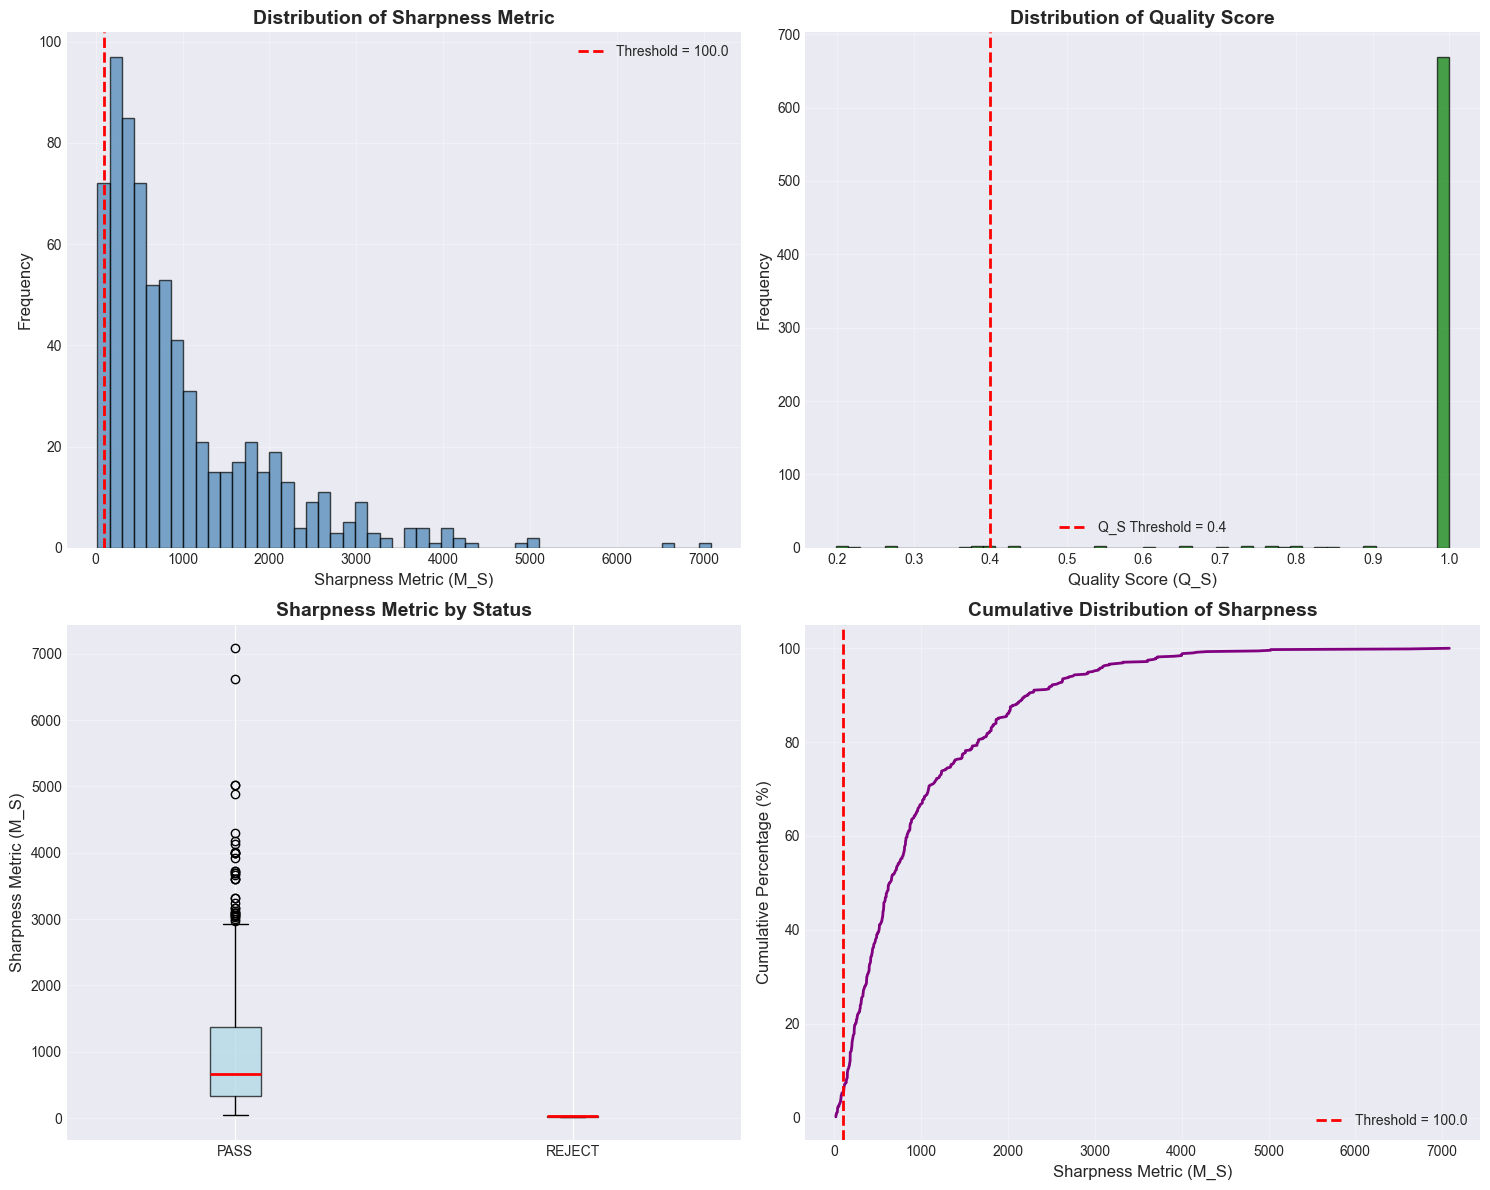


✓ Saved: ..\data\interim\sharpness_distribution.png


In [7]:
fig, axes = plt.subplots(2, 2, figsize=(15, 12))

# 1. Histogram of Sharpness Metric
ax1 = axes[0, 0]
ax1.hist(
    df_results["sharpness_metric"],
    bins=50,
    color="steelblue",
    alpha=0.7,
    edgecolor="black",
)
ax1.axvline(
    SHARPNESS_THRESHOLD,
    color="red",
    linestyle="--",
    linewidth=2,
    label=f"Threshold = {SHARPNESS_THRESHOLD}",
)
ax1.set_xlabel("Sharpness Metric (M_S)", fontsize=12)
ax1.set_ylabel("Frequency", fontsize=12)
ax1.set_title("Distribution of Sharpness Metric", fontsize=14, fontweight="bold")
ax1.legend(fontsize=10)
ax1.grid(True, alpha=0.3)

# 2. Histogram of Quality Score
ax2 = axes[0, 1]
ax2.hist(
    df_results["quality_score"], bins=50, color="green", alpha=0.7, edgecolor="black"
)
ax2.axvline(
    QUALITY_THRESHOLD,
    color="red",
    linestyle="--",
    linewidth=2,
    label=f"Q_S Threshold = {QUALITY_THRESHOLD}",
)
ax2.set_xlabel("Quality Score (Q_S)", fontsize=12)
ax2.set_ylabel("Frequency", fontsize=12)
ax2.set_title("Distribution of Quality Score", fontsize=14, fontweight="bold")
ax2.legend(fontsize=10)
ax2.grid(True, alpha=0.3)

# 3. Box Plot by Status
ax3 = axes[1, 0]
pass_metrics = df_results[df_results["status"] == "PASS"]["sharpness_metric"]
reject_metrics = df_results[df_results["status"] == "REJECT"]["sharpness_metric"]
ax3.boxplot(
    [pass_metrics, reject_metrics],
    labels=["PASS", "REJECT"],
    patch_artist=True,
    boxprops=dict(facecolor="lightblue", alpha=0.7),
    medianprops=dict(color="red", linewidth=2),
)
ax3.set_ylabel("Sharpness Metric (M_S)", fontsize=12)
ax3.set_title("Sharpness Metric by Status", fontsize=14, fontweight="bold")
ax3.grid(True, alpha=0.3, axis="y")

# 4. Cumulative Distribution
ax4 = axes[1, 1]
sorted_metrics = np.sort(df_results["sharpness_metric"])
cumulative = np.arange(1, len(sorted_metrics) + 1) / len(sorted_metrics) * 100
ax4.plot(sorted_metrics, cumulative, linewidth=2, color="purple")
ax4.axvline(
    SHARPNESS_THRESHOLD,
    color="red",
    linestyle="--",
    linewidth=2,
    label=f"Threshold = {SHARPNESS_THRESHOLD}",
)
ax4.set_xlabel("Sharpness Metric (M_S)", fontsize=12)
ax4.set_ylabel("Cumulative Percentage (%)", fontsize=12)
ax4.set_title("Cumulative Distribution of Sharpness", fontsize=14, fontweight="bold")
ax4.legend(fontsize=10)
ax4.grid(True, alpha=0.3)

plt.tight_layout()
plt.savefig(OUTPUT_DIR / "sharpness_distribution.png", dpi=150, bbox_inches="tight")
plt.show()

print(f"\n✓ Saved: {OUTPUT_DIR / 'sharpness_distribution.png'}")

## 6. VISUAL COMPARISON: SHARP vs BLURRY

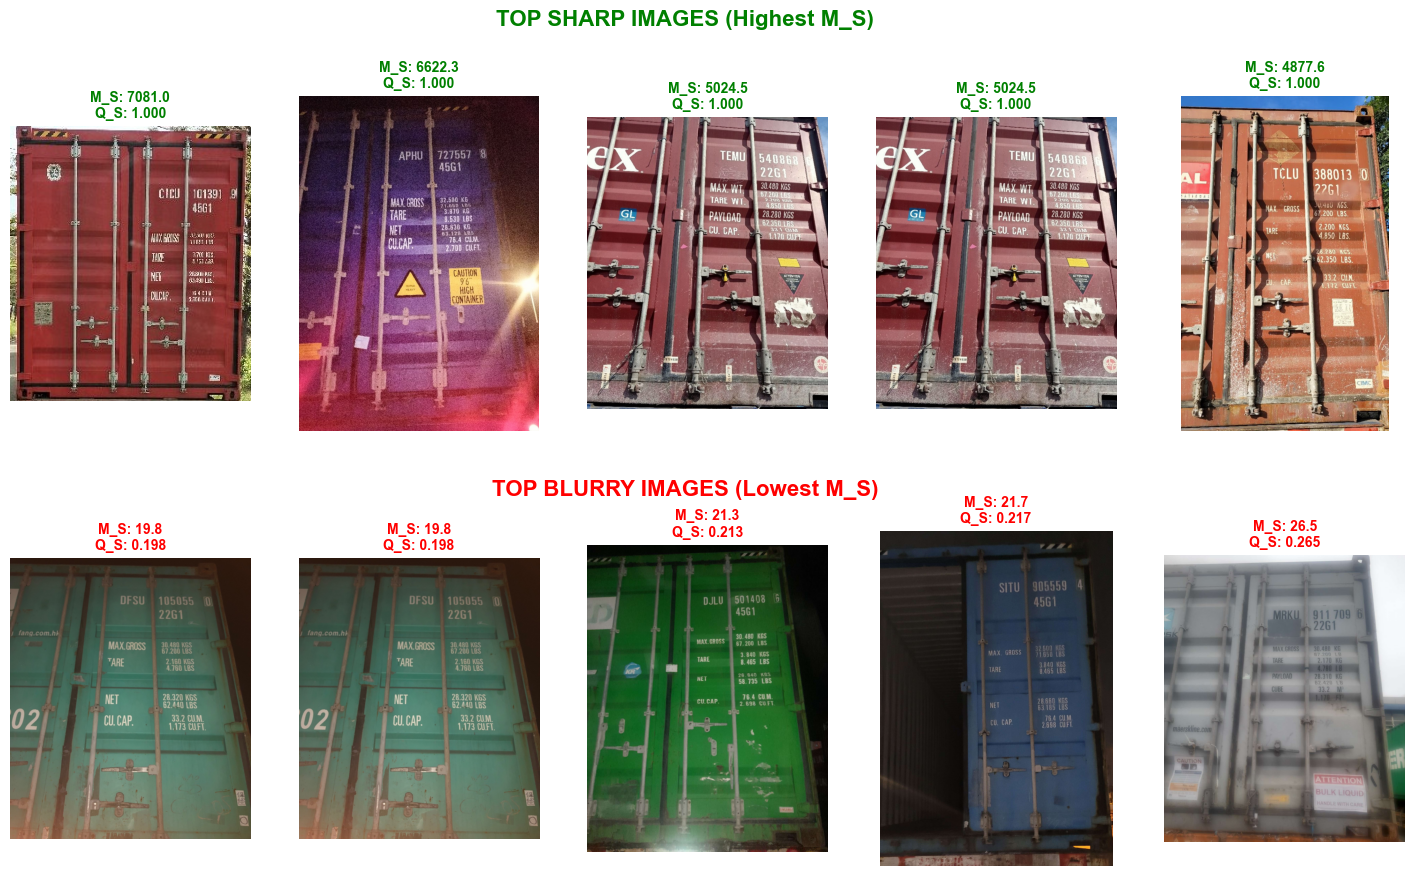


✓ Saved: ..\data\interim\sharpness_comparison.png


In [8]:
def visualize_sharpness_comparison(df: pd.DataFrame, roi_dir: Path, n_samples: int = 5):
    """
    Visualize comparison between sharpest and blurriest images.

    Args:
        df: DataFrame with analysis results
        roi_dir: Directory containing ROI images
        n_samples: Number of samples to show for each category
    """
    # Get top N sharpest and blurriest
    sharpest = df.nlargest(n_samples, "sharpness_metric")
    blurriest = df.nsmallest(n_samples, "sharpness_metric")

    fig = plt.figure(figsize=(18, 10))
    gs = GridSpec(2, n_samples, figure=fig, hspace=0.3, wspace=0.2)

    # Plot sharpest images
    fig.text(
        0.5,
        0.95,
        "TOP SHARP IMAGES (Highest M_S)",
        ha="center",
        fontsize=16,
        fontweight="bold",
        color="green",
    )

    for i, (idx, row) in enumerate(sharpest.iterrows()):
        img_path = roi_dir / row["filename"]
        img = cv2.imread(str(img_path))
        img_rgb = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

        ax = fig.add_subplot(gs[0, i])
        ax.imshow(img_rgb)
        ax.set_title(
            f"M_S: {row['sharpness_metric']:.1f}\nQ_S: {row['quality_score']:.3f}",
            fontsize=10,
            color="green",
            fontweight="bold",
        )
        ax.axis("off")

    # Plot blurriest images
    fig.text(
        0.5,
        0.48,
        "TOP BLURRY IMAGES (Lowest M_S)",
        ha="center",
        fontsize=16,
        fontweight="bold",
        color="red",
    )

    for i, (idx, row) in enumerate(blurriest.iterrows()):
        img_path = roi_dir / row["filename"]
        img = cv2.imread(str(img_path))
        img_rgb = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

        ax = fig.add_subplot(gs[1, i])
        ax.imshow(img_rgb)
        ax.set_title(
            f"M_S: {row['sharpness_metric']:.1f}\nQ_S: {row['quality_score']:.3f}",
            fontsize=10,
            color="red",
            fontweight="bold",
        )
        ax.axis("off")

    plt.savefig(OUTPUT_DIR / "sharpness_comparison.png", dpi=150, bbox_inches="tight")
    plt.show()
    print(f"\n✓ Saved: {OUTPUT_DIR / 'sharpness_comparison.png'}")


# Run visualization
visualize_sharpness_comparison(df_results, ROI_DIR, n_samples=5)

## 7. THRESHOLD CALIBRATION ANALYSIS

In [9]:
# Test different threshold values
threshold_candidates = [50, 75, 100, 125, 150, 200, 250]
calibration_results = []

for threshold in threshold_candidates:
    df_temp = df_results.copy()
    df_temp["quality_temp"] = df_temp["sharpness_metric"] / threshold
    df_temp["quality_temp"] = df_temp["quality_temp"].clip(upper=1.0)
    df_temp["pass_temp"] = df_temp["quality_temp"] >= QUALITY_THRESHOLD

    pass_count = df_temp["pass_temp"].sum()
    pass_rate = pass_count / len(df_temp) * 100

    calibration_results.append(
        {
            "threshold": threshold,
            "pass_count": pass_count,
            "pass_rate": pass_rate,
            "reject_count": len(df_temp) - pass_count,
        }
    )

df_calibration = pd.DataFrame(calibration_results)
print("\n" + "=" * 60)
print("THRESHOLD CALIBRATION ANALYSIS")
print("=" * 60)
print(df_calibration.to_string(index=False))
print("=" * 60)


THRESHOLD CALIBRATION ANALYSIS
 threshold  pass_count  pass_rate  reject_count
        50         704  99.716714             2
        75         699  99.008499             7
       100         692  98.016997            14
       125         690  97.733711            16
       150         686  97.167139            20
       200         676  95.750708            30
       250         669  94.759207            37


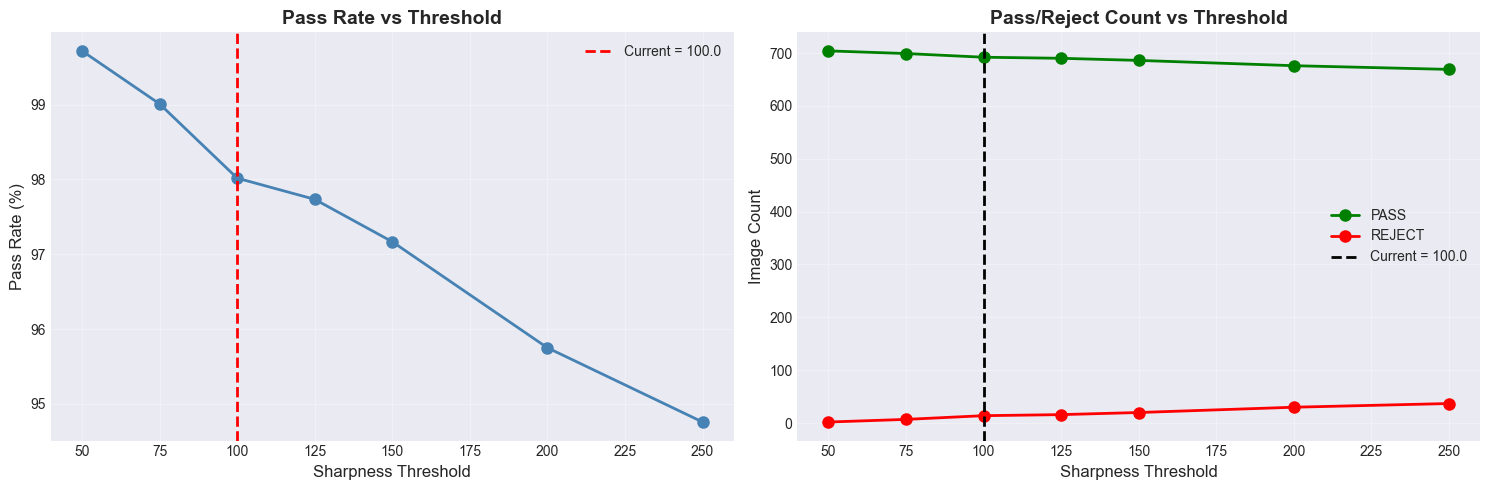


✓ Saved: ..\data\interim\threshold_calibration.png


In [10]:
# Visualize calibration results
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 5))

# Pass rate vs threshold
ax1.plot(
    df_calibration["threshold"],
    df_calibration["pass_rate"],
    marker="o",
    linewidth=2,
    markersize=8,
    color="steelblue",
)
ax1.axvline(
    SHARPNESS_THRESHOLD,
    color="red",
    linestyle="--",
    linewidth=2,
    label=f"Current = {SHARPNESS_THRESHOLD}",
)
ax1.set_xlabel("Sharpness Threshold", fontsize=12)
ax1.set_ylabel("Pass Rate (%)", fontsize=12)
ax1.set_title("Pass Rate vs Threshold", fontsize=14, fontweight="bold")
ax1.grid(True, alpha=0.3)
ax1.legend(fontsize=10)

# Image count by status
ax2.plot(
    df_calibration["threshold"],
    df_calibration["pass_count"],
    marker="o",
    linewidth=2,
    markersize=8,
    label="PASS",
    color="green",
)
ax2.plot(
    df_calibration["threshold"],
    df_calibration["reject_count"],
    marker="o",
    linewidth=2,
    markersize=8,
    label="REJECT",
    color="red",
)
ax2.axvline(
    SHARPNESS_THRESHOLD,
    color="black",
    linestyle="--",
    linewidth=2,
    label=f"Current = {SHARPNESS_THRESHOLD}",
)
ax2.set_xlabel("Sharpness Threshold", fontsize=12)
ax2.set_ylabel("Image Count", fontsize=12)
ax2.set_title("Pass/Reject Count vs Threshold", fontsize=14, fontweight="bold")
ax2.grid(True, alpha=0.3)
ax2.legend(fontsize=10)

plt.tight_layout()
plt.savefig(OUTPUT_DIR / "threshold_calibration.png", dpi=150, bbox_inches="tight")
plt.show()

print(f"\n✓ Saved: {OUTPUT_DIR / 'threshold_calibration.png'}")

## 8. EDGE CASE ANALYSIS: BORDERLINE IMAGES

In [11]:
# Find images near the threshold boundary
threshold_value = SHARPNESS_THRESHOLD * QUALITY_THRESHOLD
margin = 20  # Variance units

borderline = df_results[
    (df_results["sharpness_metric"] >= threshold_value - margin)
    & (df_results["sharpness_metric"] <= threshold_value + margin)
].sort_values("sharpness_metric")

print(f"\nBorderline Images (M_S within ±{margin} of threshold):")
print(f"Total: {len(borderline)}")
print(
    borderline[["filename", "sharpness_metric", "quality_score", "status"]].to_string(
        index=False
    )
)


Borderline Images (M_S within ±20 of threshold):
Total: 18
   filename  sharpness_metric  quality_score status
0039113.jpg         21.315477       0.213155 REJECT
0039038.jpg         21.733358       0.217334 REJECT
0026565.jpg         26.485271       0.264853 REJECT
0015435.jpg         26.485271       0.264853 REJECT
0034800.jpg         27.129021       0.271290 REJECT
0013073.jpg         36.741147       0.367411 REJECT
0013943.jpg         37.519357       0.375194 REJECT
0020968.jpg         37.519357       0.375194 REJECT
0015771.jpg         37.519357       0.375194 REJECT
0035551.jpg         39.075869       0.390759 REJECT
0011432.jpg         39.075869       0.390759 REJECT
0006565.jpg         39.075869       0.390759 REJECT
0018658.jpg         42.346325       0.423463   PASS
0042536.jpg         42.964845       0.429648   PASS
0003380.jpg         54.339430       0.543394   PASS
0021605.jpg         54.339430       0.543394   PASS
0032549.jpg         54.797989       0.547980   PASS
0028

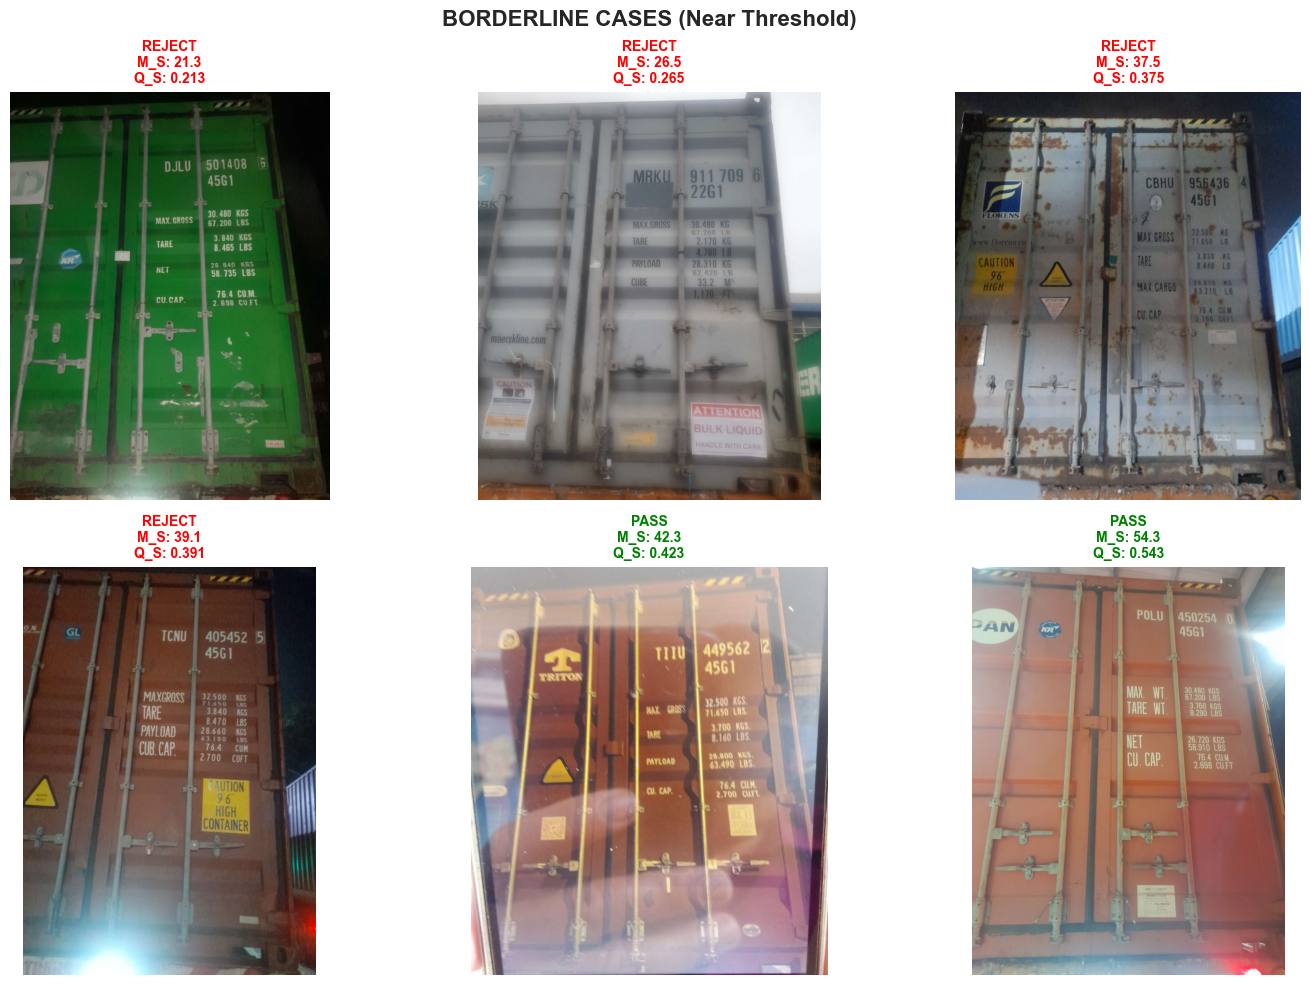


✓ Saved: ..\data\interim\borderline_cases.png


In [12]:
# Visualize borderline cases
if len(borderline) > 0:
    n_show = min(6, len(borderline))
    sample_borderline = borderline.iloc[:: max(1, len(borderline) // n_show)][:n_show]

    fig, axes = plt.subplots(2, 3, figsize=(15, 10))
    axes = axes.flatten()

    fig.suptitle("BORDERLINE CASES (Near Threshold)", fontsize=16, fontweight="bold")

    for i, (idx, row) in enumerate(sample_borderline.iterrows()):
        if i >= n_show:
            break

        img_path = ROI_DIR / row["filename"]
        img = cv2.imread(str(img_path))
        img_rgb = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

        color = "green" if row["status"] == "PASS" else "red"

        axes[i].imshow(img_rgb)
        axes[i].set_title(
            f"{row['status']}\n"
            f"M_S: {row['sharpness_metric']:.1f}\n"
            f"Q_S: {row['quality_score']:.3f}",
            fontsize=10,
            color=color,
            fontweight="bold",
        )
        axes[i].axis("off")

    # Hide unused subplots
    for i in range(len(sample_borderline), len(axes)):
        axes[i].axis("off")

    plt.tight_layout()
    plt.savefig(OUTPUT_DIR / "borderline_cases.png", dpi=150, bbox_inches="tight")
    plt.show()
    print(f"\n✓ Saved: {OUTPUT_DIR / 'borderline_cases.png'}")
else:
    print("No borderline cases found.")

## 9. SAVE RESULTS

In [13]:
# Save detailed report
output_file = OUTPUT_DIR / "sharpness_check_report.csv"
df_results.to_csv(output_file, index=False)
print(f"\n✓ Saved: {output_file}")
print(f"  Total records: {len(df_results)}")

# Save summary statistics
summary = {
    "total_images": len(df_results),
    "pass_count": (df_results["status"] == "PASS").sum(),
    "reject_count": (df_results["status"] == "REJECT").sum(),
    "pass_rate": (df_results["status"] == "PASS").sum() / len(df_results) * 100,
    "threshold_used": SHARPNESS_THRESHOLD,
    "quality_threshold": QUALITY_THRESHOLD,
    "metric_mean": df_results["sharpness_metric"].mean(),
    "metric_median": df_results["sharpness_metric"].median(),
    "metric_std": df_results["sharpness_metric"].std(),
    "metric_min": df_results["sharpness_metric"].min(),
    "metric_max": df_results["sharpness_metric"].max(),
}

summary_file = OUTPUT_DIR / "sharpness_summary.txt"
with open(summary_file, "w") as f:
    f.write("SHARPNESS ANALYSIS SUMMARY\n")
    f.write("=" * 50 + "\n\n")
    for key, value in summary.items():
        f.write(f"{key}: {value}\n")

print(f"✓ Saved: {summary_file}")


✓ Saved: ..\data\interim\sharpness_check_report.csv
  Total records: 706
✓ Saved: ..\data\interim\sharpness_summary.txt


## 10. CONCLUSIONS & RECOMMENDATIONS

In [14]:
print("\n" + "=" * 60)
print("TASK 3: SHARPNESS ANALYSIS - CONCLUSIONS")
print("=" * 60)
print(f"\n1. CURRENT CONFIGURATION:")
print(f"   - Sharpness Threshold: {SHARPNESS_THRESHOLD}")
print(f"   - Quality Threshold (Q_S): {QUALITY_THRESHOLD}")
print(f"   - Effective M_S cutoff: {SHARPNESS_THRESHOLD * QUALITY_THRESHOLD}")

print(f"\n2. RESULTS:")
print(f"   - Total Images: {len(df_results)}")
print(
    f"   - PASS: {(df_results['status'] == 'PASS').sum()} ({(df_results['status'] == 'PASS').sum()/len(df_results)*100:.2f}%)"
)
print(
    f"   - REJECT: {(df_results['status'] == 'REJECT').sum()} ({(df_results['status'] == 'REJECT').sum()/len(df_results)*100:.2f}%)"
)

print(f"\n3. METRIC STATISTICS:")
print(f"   - Mean: {df_results['sharpness_metric'].mean():.2f}")
print(f"   - Median: {df_results['sharpness_metric'].median():.2f}")
print(f"   - Std Dev: {df_results['sharpness_metric'].std():.2f}")
print(
    f"   - Range: [{df_results['sharpness_metric'].min():.2f}, {df_results['sharpness_metric'].max():.2f}]"
)

print(f"\n4. RECOMMENDATIONS:")
if df_results["sharpness_metric"].median() < SHARPNESS_THRESHOLD * QUALITY_THRESHOLD:
    print(f"   ⚠️  Median M_S is below effective threshold.")
    print(f"   → Consider lowering threshold or improving data quality.")
else:
    print(f"   ✓ Median M_S is above effective threshold - good separation.")

reject_rate = (df_results["status"] == "REJECT").sum() / len(df_results) * 100
if reject_rate > 30:
    print(f"   ⚠️  High rejection rate ({reject_rate:.1f}%)")
    print(f"   → Review borderline cases and consider threshold adjustment.")
elif reject_rate < 5:
    print(f"   ⚠️  Very low rejection rate ({reject_rate:.1f}%)")
    print(f"   → Threshold might be too lenient.")
else:
    print(f"   ✓ Rejection rate ({reject_rate:.1f}%) is reasonable.")

print(f"\n5. NEXT STEPS:")
print(f"   - Review visualizations to validate threshold choice")
print(f"   - Examine borderline cases for quality assessment")
print(f"   - Proceed to Task 4: Statistical Analysis (BRISQUE)")
print("=" * 60)


TASK 3: SHARPNESS ANALYSIS - CONCLUSIONS

1. CURRENT CONFIGURATION:
   - Sharpness Threshold: 100.0
   - Quality Threshold (Q_S): 0.4
   - Effective M_S cutoff: 40.0

2. RESULTS:
   - Total Images: 706
   - PASS: 692 (98.02%)
   - REJECT: 14 (1.98%)

3. METRIC STATISTICS:
   - Mean: 981.94
   - Median: 639.68
   - Std Dev: 960.97
   - Range: [19.79, 7081.04]

4. RECOMMENDATIONS:
   ✓ Median M_S is above effective threshold - good separation.
   ⚠️  Very low rejection rate (2.0%)
   → Threshold might be too lenient.

5. NEXT STEPS:
   - Review visualizations to validate threshold choice
   - Examine borderline cases for quality assessment
   - Proceed to Task 4: Statistical Analysis (BRISQUE)
